# Registration: Memory-Time Trade-off <a href="https://mybinder.org/v2/gh/InsightSoftwareConsortium/SimpleITK-Notebooks/master?filepath=Python%2F64_Registration_Memory_Time_Tradeoff.ipynb"><img style="float: right;" src="https://mybinder.org/badge_logo.svg"></a>

When developing a registration algorithm or when selecting parameter value settings for an existing algorithm our choices are dictated by two, often opposing, constraints:
<ul>
<li>Required accuracy.</li>
<li>Allotted time.</li>
</ul>

As the goal of registration is to align multiple data elements into the same coordinate system, it is only natural that the primary focus is on accuracy. In most cases the reported accuracy is obtained without constraining the algorithm's execution time. Don't forget to provide the running times even if they are not critical for your particular application as they may be critical for others. 

With regard to the emphasis on execution time, on one end of the spectrum we have longitudinal studies where time constraints are relatively loose. In this setting a registration taking an hour may be perfectly acceptable. At the other end of the spectrum we have intra-operative registration. In this setting, registration is expected to complete within seconds or minutes. The  underlying reasons for the tight timing constraints in this setting have to do with the detrimental effects of prolonged anesthesia and with the increased costs of operating room time. While short execution times are important, simply completing the registration on time without sufficient accuracy is also unacceptable.  

This notebook illustrates a straightforward approach for reducing the computational complexity of registration for intra-operative use via preprocessing and increased memory usage, a case of the [memory-time trade-off](https://en.wikipedia.org/wiki/Space%E2%80%93time_tradeoff). 

The computational cost of registration is primarily associated with interpolation, required for evaluating the similarity metric. Ideally we would like to use the fastest possible interpolation method, nearest neighbor. Unfortunately, nearest neighbor interpolation most often yields sub-optimal results. A straightforward solution is to pre-operatively create a super-sampled version of the moving-image using higher order interpolation*. We then perform registration using the super-sampled image, with nearest neighbor interpolation.

Tallying up time and memory usage we see that:

<table>
  <tr><td></td> <td><b>time</b></td><td><b>memory</b></td></tr>
  <tr><td><b>pre-operative</b></td> <td>increase</td><td>increase</td></tr>
  <tr><td><b>intra-operative</b></td> <td>decrease</td><td>increase</td></tr>
</table><br><br>  


<font size="-1">*A better approach is to use single image super resolution techniques such as the one described in A. Rueda, N. Malpica, E. Romero,"Single-image super-resolution of brain MR images using overcomplete dictionaries", <i>Med Image Anal.</i>, 17(1):113-132, 2013.</font> 


In [1]:
import SimpleITK as sitk

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

# utility method that either downloads data from the Girder repository or
# if already downloaded returns the file name for reading from disk (cached data)
%run update_path_to_download_script
from downloaddata import fetch_data as fdata

import registration_utilities as ru

from ipywidgets import interact, fixed


def register_images(fixed_image, moving_image, initial_transform, interpolator):

    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
    registration_method.SetMetricSamplingPercentage(0.01)
    registration_method.SetInterpolator(interpolator)
    registration_method.SetOptimizerAsGradientDescent(
        learningRate=1.0, numberOfIterations=1000
    )
    registration_method.SetOptimizerScalesFromPhysicalShift()
    registration_method.SetInitialTransform(initial_transform, inPlace=False)

    final_transform = registration_method.Execute(fixed_image, moving_image)

    return (final_transform, registration_method.GetOptimizerStopConditionDescription())

## Load data

We use the the training data from the Retrospective Image Registration Evaluation (<a href="http://www.insight-journal.org/rire/">RIRE</a>) project.

The RIRE reference, ground truth, data consists of a set of corresponding points in the fixed and moving coordinate systems. These points were obtained from fiducials embedded in the patient's skull and are thus sparse (eight points). We use these to compute the rigid transformation between the two coordinate systems, and then generate a dense reference. This generated reference data is more similar to the data you would use for registration evaluation.

In [2]:
fixed_image = sitk.ReadImage(fdata("training_001_ct.mha"), sitk.sitkFloat32)
moving_image = sitk.ReadImage(fdata("training_001_mr_T1.mha"), sitk.sitkFloat32)
fixed_fiducial_points, moving_fiducial_points = ru.load_RIRE_ground_truth(
    fdata("ct_T1.standard")
)

R, t = ru.absolute_orientation_m(fixed_fiducial_points, moving_fiducial_points)
reference_transform = sitk.Euler3DTransform()
reference_transform.SetMatrix(R.flatten())
reference_transform.SetTranslation(t)

# Generate a reference dataset from the reference transformation (corresponding points in the fixed and moving images).
fixed_points = ru.generate_random_pointset(image=fixed_image, num_points=1000)
moving_points = [reference_transform.TransformPoint(p) for p in fixed_points]

interact(
    lambda image1_z, image2_z, image1, image2: ru.display_scalar_images(
        image1_z, image2_z, image1, image2
    ),
    image1_z=(0, fixed_image.GetSize()[2] - 1),
    image2_z=(0, moving_image.GetSize()[2] - 1),
    image1=fixed(fixed_image),
    image2=fixed(moving_image),
);

Fetching training_001_ct.mha
Fetching training_001_mr_T1.mha
Fetching ct_T1.standard


interactive(children=(IntSlider(value=14, description='image1_z', max=28), IntSlider(value=12, description='im…

## Invest time and memory in exchange for future time savings

We now resample our moving image to a finer spatial resolution.

In [3]:
# Isotropic voxels with 1mm spacing.
new_spacing = [1.0] * moving_image.GetDimension()

# Create resampled image using new spacing and size.
original_size = moving_image.GetSize()
original_spacing = moving_image.GetSpacing()
resampled_image_size = [
    int(spacing / new_s * size)
    for spacing, size, new_s in zip(original_spacing, original_size, new_spacing)
]
resampled_moving_image = sitk.Image(resampled_image_size, moving_image.GetPixelID())
resampled_moving_image.SetSpacing(new_spacing)
resampled_moving_image.SetOrigin(moving_image.GetOrigin())
resampled_moving_image.SetDirection(moving_image.GetDirection())

# Resample original image using identity transform and the BSpline interpolator.
resample = sitk.ResampleImageFilter()
resample.SetReferenceImage(resampled_moving_image)
resample.SetInterpolator(sitk.sitkBSpline)
resample.SetTransform(sitk.Transform())
resampled_moving_image = resample.Execute(moving_image)

print(f"Original image size and spacing: {original_size} {original_spacing}")
print(
    f"Resampled image size and spacing: {resampled_moving_image.GetSize()} {resampled_moving_image.GetSpacing()}"
)
print(
    f"Memory ratio: 1 : {(np.array(resampled_image_size)/np.array(original_size).astype(float)).prod()}"
)

Original image size and spacing: (256, 256, 26) (1.25, 1.25, 4.0)
Resampled image size and spacing: (320, 320, 104) (1.0, 1.0, 1.0)
Memory ratio: 1 : 6.25


Another option for resampling an image, without any transformation, is to use the ExpandImageFilter or 
in its functional form SimpleITK::Expand. This filter accepts the interpolation method and an integral expansion factor. This is less flexible than the resample filter as we have less control over the resulting image's spacing. 
On the other hand this requires less effort from the developer, a single line of code as compared to the cell above:

resampled_moving_image = sitk.Expand(moving_image, 
                                     [int(original_s/new_s + 0.5) for original_s, new_s in zip(original_spacing, new_spacing)], 
                                     sitk.sitkBSpline)


## Registration

### Initial Alignment

We will use the same initial alignment for both registrations.

In [4]:
initial_transform = sitk.CenteredTransformInitializer(
    fixed_image,
    moving_image,
    sitk.Euler3DTransform(),
    sitk.CenteredTransformInitializerFilter.GEOMETRY,
)

### Original Resolution

For this registration we use the original resolution and linear interpolation.

In [5]:
%%timeit -r1 -n1
# The arguments to the timeit magic specify that this cell should only be run once.

# We define this variable as global so that it is accessible outside of the cell (timeit wraps the code in the cell
# making all variables local, unless explicitly declared global).
global original_resolution_errors

final_transform, optimizer_termination = register_images(
    fixed_image, moving_image, initial_transform, sitk.sitkLinear
)
(
    final_errors_mean,
    final_errors_std,
    _,
    final_errors_max,
    original_resolution_errors,
) = ru.registration_errors(final_transform, fixed_points, moving_points)

print(optimizer_termination)
print(
    f"After registration, errors in millimeters, mean(std): {final_errors_mean:.2f}({final_errors_std:.2f}), max: {final_errors_max:.2f}"
)

GradientDescentOptimizerv4Template: Convergence checker passed at iteration 272.
After registration, errors in millimeters, mean(std): 1.97(0.87), max: 4.12
3.09 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Higher Resolution

For this registration we use the higher resolution image and nearest neighbor interpolation.

In [6]:
%%timeit -r1 -n1
# The arguments to the timeit magic specify that this cell should only be run once.

# We define this variable as global so that it is accessible outside of the cell (timeit wraps the code in the cell
# making all variables local, unless explicitly declared global).
global resampled_resolution_errors

final_transform, optimizer_termination = register_images(
    fixed_image, resampled_moving_image, initial_transform, sitk.sitkNearestNeighbor
)
(
    final_errors_mean,
    final_errors_std,
    _,
    final_errors_max,
    resampled_resolution_errors,
) = ru.registration_errors(final_transform, fixed_points, moving_points)

print(optimizer_termination)
print(
    f"After registration, errors in millimeters, mean(std): {final_errors_mean:.2f}({final_errors_std:.2f}), max: {final_errors_max:.2f}"
)

GradientDescentOptimizerv4Template: Convergence checker passed at iteration 172.
After registration, errors in millimeters, mean(std): 1.36(0.64), max: 2.83
2.36 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Compare the error distributions

To fairly compare the two registration above we look at their running times (see results above) and their 
error distributions (plotted below).

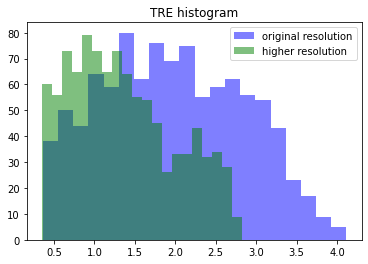

In [7]:
plt.hist(
    original_resolution_errors,
    bins=20,
    alpha=0.5,
    label="original resolution",
    color="blue",
)
plt.hist(
    resampled_resolution_errors,
    bins=20,
    alpha=0.5,
    label="higher resolution",
    color="green",
)
plt.legend()
plt.title("TRE histogram");

## Conclusions

It appears that the memory-time trade-off works in our favor, but is this always the case? Well, you will have to answer that for yourself.

Some immediate things you can try:
* Change the interpolation method for the "original resolution" registration to nearest neighbor.
* Change the resolution of the resampled image - will a higher resolution always result in faster running times?